# Copyright Netherlands eScience Center <br>
**Function     : Forecast Lorenz 84 system with autoregressive model with Gaussian noise** <br>
**Author       : Yang Liu** <br>
**First Built   : 2020.11.28** <br>
**Last Update   : 2020.11.28** <br>
**Library      : Pytorth, Numpy, NetCDF4, os, iris, cartopy, dlacs, matplotlib**<br>
Description     : This notebook includes the methods and results of forecasting Lorenz 84 system
              with autoregressive model with Gaussian noise.<br>

The Lorens-84 model is described by Edward Lorens in his 1984 paper:<br>
Lorenz, E. N. (1984). Irregularity: A fundamental property of the atmosphere. Tellus A, 36(2), 98-110.<br>

Return Values   : Time series and figures <br>

In [1]:
%matplotlib inline

import sys
import warnings
import numbers

# for data loading
import os
from netCDF4 import Dataset
# for pre-processing and machine learning
import numpy as np
import csv
import sklearn
#import scipy
import torch
import torch.nn.functional

# for autoregressive modeling
# auto regression
# from statsmodels.tsa.ar_model import AR # deprecated 
# https://www.statsmodels.org/devel/generated/statsmodels.tsa.ar_model.AR.html#statsmodels.tsa.ar_model.AR
from statsmodels.tsa.ar_model import AutoReg
# vector autoregression
from statsmodels.tsa.api import VAR
from statsmodels.graphics.tsaplots import plot_acf

#sys.path.append(os.path.join('C:','Users','nosta','ML4Climate','Scripts','DLACs'))
sys.path.append("C:\\Users\\nosta\\ML4Climate\\Scripts\\DLACs")
#sys.path.append("../")
import dlacs
import dlacs.BayesConvLSTM
import dlacs.preprocess
import dlacs.function
import dlacs.saveNetCDF
import dlacs.metric

# for visualization
import dlacs.visual
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from mpl_toolkits.mplot3d import Axes3D
import iris # also helps with regriding
import cartopy
import cartopy.crs as ccrs

# ignore all the DeprecationWarnings by pytorch
if not sys.warnoptions:
    warnings.simplefilter("ignore")
###############################################################################79

The testing device is Dell Inspirion 5680 with Intel Core i7-8700 x64 CPU and Nvidia GTX 1060 6GB GPU.<br>
Here is a benchmark about cpu v.s. gtx 1060 <br>
https://www.analyticsindiamag.com/deep-learning-tensorflow-benchmark-intel-i5-4210u-vs-geforce-nvidia-1060-6gb/

In [2]:
# constants
constant = {'g' : 9.80616,      # gravititional acceleration [m / s2]
            'R' : 6371009,      # radius of the earth [m]
            'cp': 1004.64,      # heat capacity of air [J/(Kg*K)]
            'Lv': 2500000,      # Latent heat of vaporization [J/Kg]
            'R_dry' : 286.9,    # gas constant of dry air [J/(kg*K)]
            'R_vap' : 461.5,    # gas constant for water vapour [J/(kg*K)]
            'rho' : 1026,       # sea water density [kg/m3]
            }

In [3]:
################################################################################# 
#########                           datapath                             ########
#################################################################################
ಠ_ಠ = "I'm a valid variable name!"
print(ಠ_ಠ)
# model type
model_type = 'lorenz84ex' # choose lorenz84 / lorenz84ex / lorenz84AA
# datapath for output
output_path = 'C:\\Users\\nosta\\ML4Climate\\PredictArctic\\BayesMaps\\Lorenz84\\bayes\\benchmark'
# data path of experiment
#path_e3000_p1000000_stdx4 = 'C:\\Users\\nosta\\ML4Climate\\PredictArctic\\BayesMaps\\Lorenz84\\bayes\\fullseries_ex\\epoch3000_p1000000_stdx4'
#path_e3000_p10000000_stdx4 = 'C:\\Users\\nosta\\ML4Climate\\PredictArctic\\BayesMaps\\Lorenz84\\bayes\\fullseries_ex\\epoch3000_p10000000_stdx4'

I'm a valid variable name!


In [4]:
if __name__=="__main__":
    #################################################################################
    ###########                configure Lorenz 84 model                  ###########
    #################################################################################
    # Lorenz paramters and initial conditions
    x_init = 1.0 # strength of the symmetric globally encircling westerly current
    y_init = 1.0 # strength of the cosine phases of a chain of superposedwaves (large scale eddies)
    z_init = 1.0 # strength of the sine phases of a chain of superposedwaves (large scale eddies)
    F = 8.0 # temperature difference between pole and equator
    G = 1.0 # thermal forcing term
    epsilon = 0.4 # intensity of periodic forcing
    a = 0.25 # mechanical damping factor for westerly wind x
    b = 4.0 # advection strength of the waves by the westerly current
    
    # assuming the damping time for the waves is 5 days (Lorens 1984)
    dt = 0.0333 # 1/30 unit of time unit (5 days)
    num_steps = 1500
    # cut-off point of initialization period
    cut_off = 0
    # target testing period
    test_len = 200

#### Ensemble<br>
##### Testing benchmark <br>
- Lorenz 84 model initial set-up <br>
original model<br>
**x=1.0, y=1.0, z=1.0, a=0.25, b=4.0, F=8.0, G=1.0** <br>
with periodic forcing<br>
**x=1.0, y=1.0, z=1.0, a=0.25, b=4.0, F=8.0, G=1.0, epsilon=0.4** <br>
with AA effect<br>
**x=1.0, y=1.0, z=1.0, a=0.25, b=4.0, F=8.0, G=1.0, epsilon=0.4, alpha = 0.025, beta = 0.00625** <br>
========================================================================================================<br>
##### AR
The methods include AR and VAR, which are based on <br>
Lütkepohl, H. (2005). New introduction to multiple time series analysis. Springer Science & Business Media.<br>
========================================================================================================<br>



In [5]:
    #################################################################################
    ###########            Lorens 84 model + periodic forcing             ###########
    #################################################################################
    def lorenz84_ex(x, y, z, t, a = 0.25, b = 4.0, F = 8.0, G = 1.0, epsilon = 0.4):
        """
        Solver of Lorens-84 model with periodic external forcing.
        
        param x, y, z: location in a 3D space
        param a, b, F, G: constants and forcing
        
        The model is designed with a reference to the paper:
        Broer, H., Simó, C., & Vitolo, R. (2002). Bifurcations and strange
        attractors in the Lorenz-84 climate model with seasonal forcing. Nonlinearity, 15(4), 1205.
        
        Song, Y., Yu, Y., & Wang, H. (2011, October). The stability and chaos analysis of the
        Lorenz-84 atmosphere model with seasonal forcing. In 2011 Fourth International Workshop
        on Chaos-Fractals Theories and Applications (pp. 37-41). IEEE.
        """
        # each time step is ~ 5days, therefore the returning period are 365 / 5 = 73 times in a year
        T = 73
        omega = 2 * np.pi / T
        dx = - y**2 - z**2 - a * x + a * F * (1 + epsilon * np.cos(omega * t))
        dy = x * y - b * x * z - y + G * (1 + epsilon * np.sin(omega * t))
        dz = b * x * y + x * z - z
        
        return dx, dy, dz

In [6]:
    #################################################################################
    ###########        Launch Lorenz 84 model with periodic forcing       ###########
    #################################################################################   
    # Need one more for the initial values
    x = np.empty(num_steps)
    y = np.empty(num_steps)
    z = np.empty(num_steps)
    t = 0.0
    
    # save initial values
    x[0] = x_init
    y[0] = y_init
    z[0] = z_init
    
    # Step through "time", calculating the partial derivatives at the current point
    # and using them to estimate the next point
    for i in range(num_steps-1):
        dx, dy, dz = lorenz84_ex(x[i], y[i], z[i], t, a, b ,F, G, epsilon)
        x[i + 1] = x[i] + (dx * dt)
        y[i + 1] = y[i] + (dy * dt)
        z[i + 1] = z[i] + (dz * dt)
        t += dt

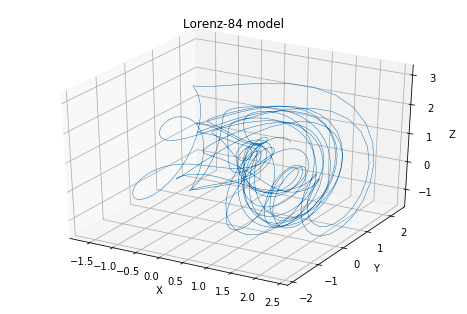

<Figure size 432x288 with 0 Axes>

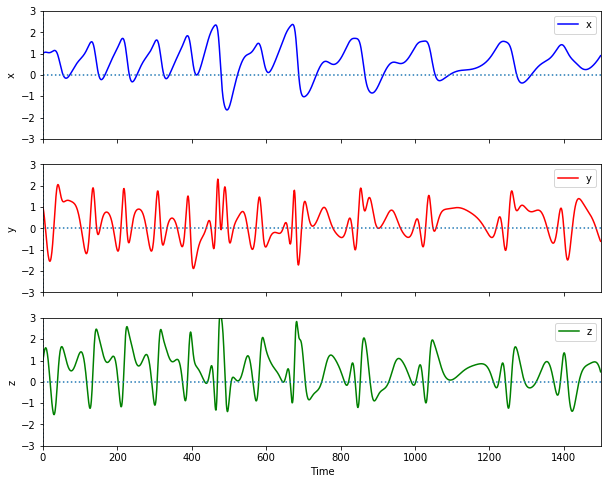

In [7]:
    #################################################################################
    ###########                 Visualize Lorens 84 model                 ###########
    #################################################################################
    # save Lorens model output
    index = np.arange(num_steps)
    # Plot
    fig00 = plt.figure(figsize=(8,5.4))
    ax = fig00.gca(projection='3d')
    ax.plot(x, y, z, lw=0.5)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title("Lorenz-84 model")
    plt.show()
        
    fig01 = plt.figure()
    fig01, (ax1,ax2,ax3) = plt.subplots(3, 1, sharex=True)
    fig01.set_size_inches(10, 8, forward=True)
    ax1.plot(index, x, 'b', label='x')
    ax2.plot(index, y, 'r', label='y')
    ax3.plot(index, z, 'g', label='z')
    
    ax1.axhline(y=0, ls = ':')
    ax2.axhline(y=0, ls = ':')
    ax3.axhline(y=0, ls = ':')
    
    ax1.axvline(x=cut_off, ls = ':')
    ax2.axvline(x=cut_off, ls = ':')
    ax3.axvline(x=cut_off, ls = ':')
    
    ax1.set_xlim(0, num_steps)
    ax2.set_xlim(0, num_steps)
    ax3.set_xlim(0, num_steps)
    
    ax1.set_ylim(-3, 3)
    ax2.set_ylim(-3, 3)
    ax3.set_ylim(-3, 3)
    
    ax1.set_ylabel("x")
    ax2.set_ylabel("y")
    ax3.set_ylabel("z")
    
    plt.xlabel("Time")
    
    ax1.legend()
    ax2.legend()
    ax3.legend()

    plt.show()

In [8]:
    print ('*******************  pre-processing  *********************')
    # time series cut-off
    if cut_off:
        x = x[cut_off:]
        y = y[cut_off:]
        z = z[cut_off:]
    print ('===================  normalize data  =====================')
    x_norm = dlacs.preprocess.operator.normalize(x)
    y_norm = dlacs.preprocess.operator.normalize(y)
    z_norm = dlacs.preprocess.operator.normalize(z)
    print('================  save the normalizing factor  =================')
    # maximum and minimum
    x_max = np.amax(x)
    x_min = np.amin(x)
    y_max = np.amax(y)
    y_min = np.amin(y)
    z_max = np.amax(z)
    z_min = np.amin(z)
    # std -> only consider the validation time
    x_std = np.std(x[-test_len:])
    y_std = np.std(y[-test_len:])
    z_std = np.std(z[-test_len:])

    # build the input data structure
    series_full = np.zeros((3, num_steps), dtype=float)
    series_full[0,:] = x[:]
    series_full[1,:] = y[:]
    series_full[2,:] = z[:]

*******************  pre-processing  *********************
===================  normalize data  =====================
================  save the normalizing factor  =================


<Figure size 432x288 with 0 Axes>

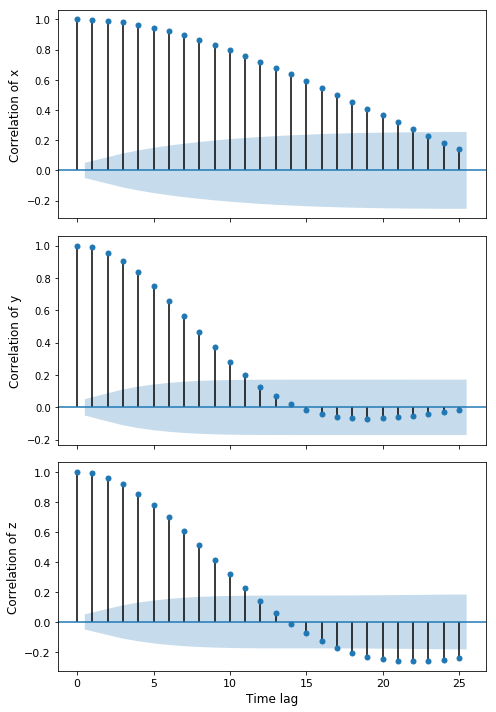

In [9]:
    #################################################################################
    ###########                 check the auto-correlation                ###########
    #################################################################################
    # about statsmodels.graphics.tsaplots.plot_acf function
    # https://www.statsmodels.org/dev/generated/statsmodels.graphics.tsaplots.plot_acf.html
    fig02 = plt.figure()
    fig02, (ax1,ax2,ax3) = plt.subplots(3, 1, sharex=True)
    fig02.set_size_inches(7, 10, forward=True)
    fig02 = plot_acf(x,lags=25,ax=ax1)
    fig02 = plot_acf(y,lags=25,ax=ax2)
    fig02 = plot_acf(z,lags=25,ax=ax3)
    
    ax1.set_title("")
    ax2.set_title("")
    ax3.set_title("")
    
    ax1.set_ylabel("Correlation of x", fontsize=12)
    ax2.set_ylabel("Correlation of y", fontsize=12)
    ax3.set_ylabel("Correlation of z", fontsize=12)
    
    plt.xlabel("Time lag", fontsize=12)
    
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
    
    plt.tight_layout()

    plt.show()
    # !! The shading indicates the significance level
    fig02.savefig(os.path.join(output_path,'autocorrelation_lorenz.png'),dpi=150)

Coefficients: [ 4.33888022e-06  4.85346559e+00 -9.51318583e+00  9.41484609e+00
 -4.70475963e+00  9.49625942e-01]


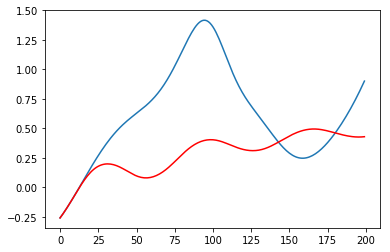

In [10]:
    #################################################################################
    ###########             perform auto-regressive modeling              ###########
    ###########                  !!!! testing only !!!!                   ###########
    #################################################################################
    # AR using module statsmodels.tsa.ar_model.AutoReg
    # https://www.statsmodels.org/devel/generated/statsmodels.tsa.ar_model.AutoReg.html#statsmodels.tsa.ar_model.AutoReg
    train, test = x[:1300], x[1300:]
    model_AR = AutoReg(train,lags=5)
    model_AR_fit = model_AR.fit()
    
    print('Coefficients: %s' % model_AR_fit.params)
    predictions = model_AR_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
    fig03 = plt.figure()
    plt.plot(test)
    plt.plot(predictions, color='red')
    plt.show()
    fig03.savefig(os.path.join(output_path,'test_AR_lorenz.png'),dpi=150)

In [16]:
    #################################################################################
    ###########           perform vector auto-regressive modeling         ###########
    ###########                  !!!! testing only !!!!                   ###########
    #################################################################################
    # VAR using module statsmodels.tsa.vector_ar.var_model.VAR
    # (example)https://www.statsmodels.org/devel/vector_ar.html
    # (VAR manual)https://www.statsmodels.org/devel/generated/statsmodels.tsa.vector_ar.var_model.VAR.html#statsmodels.tsa.vector_ar.var_model.VAR
    series_train = series_full[:,:-test_len]
    series_test = series_full[:,-test_len:]    
    # initialize VAR model
    # input shape for VAR function must be [series, variables], in this case [1500, 3]
    model_VAR = VAR(series_train.T)
    # choose the order of VAR model based on scoring
    o = model_VAR.select_order(maxlags=12)
    o.summary()

,AIC,BIC,FPE,HQIC
0,-1.314,-1.302,0.2688,-1.309
1,-15.93,-15.88,1.212e-07,-15.91
2,-28.47,-28.39,4.312e-13,-28.44
3,-38.25,-38.13,2.440e-17,-38.21
4,-47.16,-47.01,3.288e-21,-47.11
5,-54.48,-54.29,2.175e-24,-54.41
6,-60.99,-60.77,3.239e-27,-60.91
7,-66.38,-66.12,1.478e-29,-66.29
8,-71.19,-70.89,1.205e-31,-71.08
9,-74.82,-74.49,3.199e-33,-74.70


In [17]:
    # choose the optimal order and fit the model
    model_VAR_fitted = model_VAR.fit(5)
    model_VAR_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 30, Nov, 2020
Time:                     22:01:37
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -54.3003
Nobs:                     1295.00    HQIC:                  -54.4200
Log likelihood:           29818.9    FPE:                2.16025e-24
AIC:                     -54.4918    Det(Omega_mle):     2.08211e-24
--------------------------------------------------------------------
Results for equation y1
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const         0.000000         0.000002            0.153           0.879
L1.y1         4.745703         0.010132          468.367           0.000
L1.y2         0.018486         0.000966           19.138           0.000
L1.y3         0.015988

5


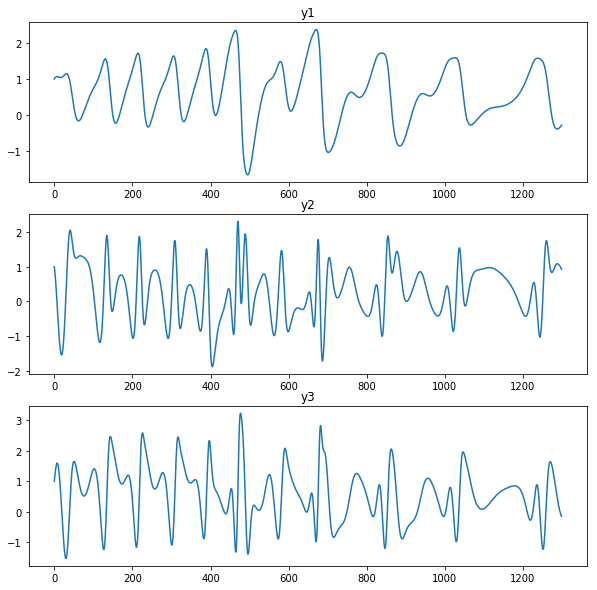

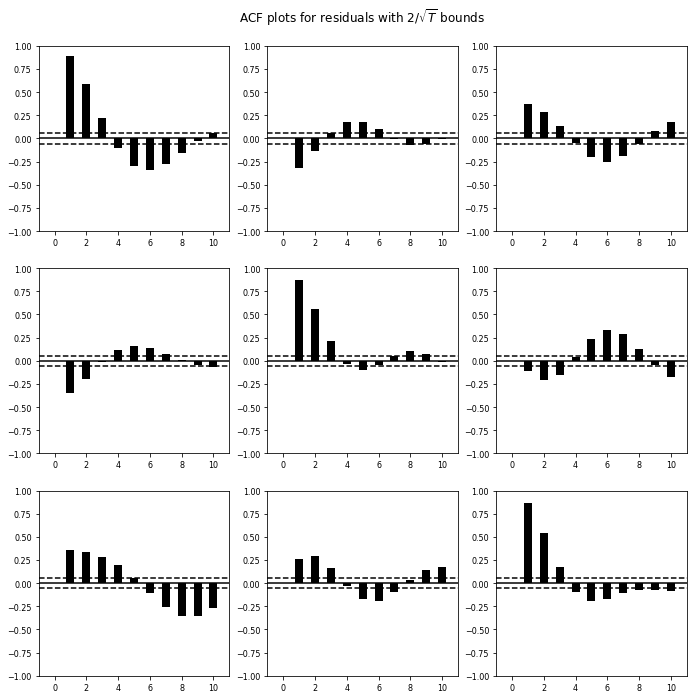

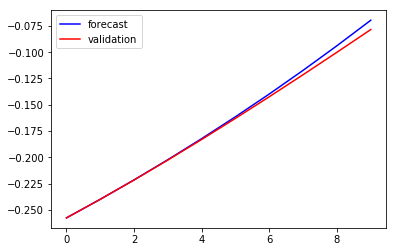

In [15]:
    #model_VAR_fitted = model_VAR.fit(5)
    #model_VAR_fitted.summary()
    # plot the input time series
    #model_VAR_fitted.plot()
    # plot time series auto-correlation function
    #model_VAR_fitted.plot_acorr()
    # get the lag order
    lag_order = model_VAR_fitted.k_ar
    print(lag_order)
    # launch forecast with initial condition
    fc = model_VAR_fitted.forecast(y=series_train[:,-lag_order:].T, steps=test_len)
    
    fig04 = plt.figure()
    plt.plot(fc[:10,0],'b',label='forecast')
    plt.plot(series_test[0,:10],'r',label='validation')
    plt.legend()
    fig04.savefig(os.path.join(output_path,'test_VAR_lorenz.png'),dpi=150)

In [12]:
    %%time
    #################################################################################
    ###########           perform vector auto-regressive modeling         ###########
    ###########                lead time depedent forecasts               ###########
    #################################################################################
    step_lead = 42
    # options for the std of gaussian noise
    type_std = "small"
    # create space to save forecast data
    deter_pred_xyz = np.zeros((3, test_len, step_lead), dtype=float)
    # save standard deviation for adding Gaussian noise
    std_noise = np.zeros((3, test_len, step_lead), dtype=float)
    for i in range(test_len):
        train_set = series_full[:,i:-test_len+i]
        # initialize VAR model
        model_VAR = VAR(train_set.T)
        model_VAR_fitted = model_VAR.fit(3)
        lag_order = model_VAR_fitted.k_ar
        pred = model_VAR_fitted.forecast(y=train_set[:,-lag_order:].T, steps=step_lead)
        deter_pred_xyz[:,i,:] = pred.T
    
        # calculate relevant std noise -> extend the array
        if type_std == 'large':
            dummy_array = np.zeros((3, step_lead + test_len), dtype=float)
            dummy_array[:,:test_len] = train_set[:,-test_len:]
            dummy_array[:,test_len:] = pred.T
            for j in range(step_lead):
                std_noise[:,i,j] = np.std(dummy_array[:,test_len-j*lag_order:test_len+j+lag_order],1)
        else:
            dummy_array = np.zeros((3, step_lead + lag_order), dtype=float)
            dummy_array[:,:lag_order] = train_set[:,-lag_order:]
            dummy_array[:,lag_order:] = pred.T
            for j in range(step_lead):
                std_noise[:,i,j] = np.std(dummy_array[:,:j+lag_order],1)

    print ('===================  adding Gaussian noise  =====================')
    ens = 20 # generate a 20 member ensemble with Gaussian noise
    deter_pred_xyz_ens = np.repeat(deter_pred_xyz[np.newaxis,:,:,:],ens,0)
    # increase the size of std array to match the forecast
    std_noise_deter = np.repeat(std_noise[np.newaxis,:,:,:],ens ,0)
    # generate Gaussian
    Gaussian_dist = np.random.normal(0, 1, (deter_pred_xyz_ens.shape))
    # generate probabilistic forecast
    prob_pred_xyz = deter_pred_xyz_ens + std_noise_deter * Gaussian_dist

===================  adding Gaussian noise  =====================
Wall time: 1.06 s


In [13]:
    ###################################################################################################
    ###########        Launch Lorenz 84 model with periodic forcing with longer series      ###########
    ###################################################################################################
    num_steps_long = num_steps + step_lead
    # Need one more for the initial values
    xx = np.empty(num_steps_long)
    yy = np.empty(num_steps_long)
    zz = np.empty(num_steps_long)
    tt = 0.0
    
    # save initial values
    xx[0] = x_init
    yy[0] = y_init
    zz[0] = z_init
    
    # Step through "time", calculating the partial derivatives at the current point
    # and using them to estimate the next point
    for i in range(num_steps_long-1):
        dx, dy, dz = lorenz84_ex(xx[i], yy[i], zz[i], tt, a, b ,F, G, epsilon)
        xx[i + 1] = xx[i] + (dx * dt)
        yy[i + 1] = yy[i] + (dy * dt)
        zz[i + 1] = zz[i] + (dz * dt)
        tt += dt

In [14]:
    ##############################################################################################################
    ###########       Compute Euclidean distance with given ensemble predictands and observation       ###########
    ##############################################################################################################
    # Euclidean distance
    def Euclidean(obs, pred):
        """
        Measure the Euclidean distance.
        ----------------------
        param obs: observation time series with the shape [dim, series]
        param pred: reference time series with the shape [dim, series]        
        """
        euclidean = np.mean(np.sqrt(np.sum((obs-pred)**2,0)))
        
        return euclidean
    
    # lead time dependent Euclidean distance of Bayesian forecast
    #euclidean_e3000_p100000_stdx4_ens = np.zeros((ens, step_lead+1), dtype=float)
    euclidean_VAR_deter = np.zeros(step_lead+1, dtype=float)
    euclidean_VAR_prob_ens = np.zeros((ens,step_lead+1), dtype=float)
    euclidean_persist = np.zeros(step_lead+1, dtype=float)
    
    
    obs = np.zeros((3, num_steps_long), dtype=float)
    obs[0,:] = xx[:]
    obs[1,:] = yy[:]
    obs[2,:] = zz[:]
    
    #predictand_e3000_p100000_stdx4_denorm = np.zeros(predictand_e3000_p100000_stdx4.shape, dtype=float)
    #predictand_e3000_p100000_stdx4_denorm[:,0,:,:] = predictand_e3000_p100000_stdx4[:,0,:,:] * (x_max - x_min) + x_min
    #predictand_e3000_p100000_stdx4_denorm[:,1,:,:] = predictand_e3000_p100000_stdx4[:,1,:,:] * (y_max - y_min) + y_min
    #predictand_e3000_p100000_stdx4_denorm[:,2,:,:] = predictand_e3000_p100000_stdx4[:,2,:,:] * (z_max - z_min) + z_min
    
    for i in range(step_lead):
        euclidean_VAR_deter[i+1] = Euclidean(obs[:,-(test_len + step_lead)+i:-step_lead+i], deter_pred_xyz[:,:,i])
        euclidean_persist[i+1] = Euclidean(obs[:,-(test_len + step_lead)+i:-step_lead+i], obs[:,-(test_len + step_lead)-1:-step_lead-1])
        for n in range(ens):
            euclidean_VAR_prob_n = Euclidean(obs[:,-(test_len + step_lead)+i:-step_lead+i], prob_pred_xyz[n,:,:,i])
            euclidean_VAR_prob_ens[n,i+1] = euclidean_VAR_prob_n
        
#             euclidean_e3000_p100000_stdx4_n = Euclidean(obs[:,-(test_len + step_lead)+i:-step_lead+i],
#                                                       predictand_e3000_p100000_stdx4_denorm[n,:,:,i])
#             euclidean_e3000_p100000_stdx4_ens[n,i+1] = euclidean_e3000_p100000_stdx4_n

#    euclidean_e3000_p100000_stdx4 = np.mean(euclidean_e3000_p100000_stdx4_ens, 0)
    euclidean_VAR_prob = np.mean(euclidean_VAR_prob_ens, 0)

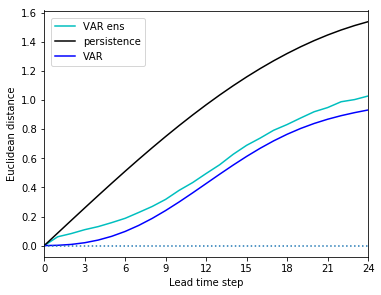

In [15]:
    #colormap=cm.tab20c(range(20))
    colormap=cm.tab10(range(10))
    # zoom in
    display_upto = 24
    
    fig05 = plt.figure()
    fig05.set_size_inches(5.4, 4.2, forward=True)
    
    plt.plot(np.arange(display_upto+1), euclidean_VAR_prob[:display_upto+1], 'c', label='VAR ens')
    plt.plot(np.arange(display_upto+1), euclidean_persist[:display_upto+1], 'k', label='persistence')
    plt.plot(np.arange(display_upto+1), euclidean_VAR_deter[:display_upto+1], 'b', label='VAR')
    plt.axhline(y=0, ls = ':')
    plt.xlim(0, display_upto)
    plt.xticks(np.arange(0,display_upto+1,3))
    
    plt.ylabel("Euclidean distance")
    plt.xlabel("Lead time step")
    
    plt.legend(frameon=True, prop={'size': 10.0}, bbox_to_anchor=(0.005,0.99), loc=2, ncol=1)
    plt.tight_layout()

    plt.show()
    fig05.savefig(os.path.join(output_path,'euclidean_VAR_prob_deter.png'),dpi=150)

<Figure size 432x288 with 0 Axes>

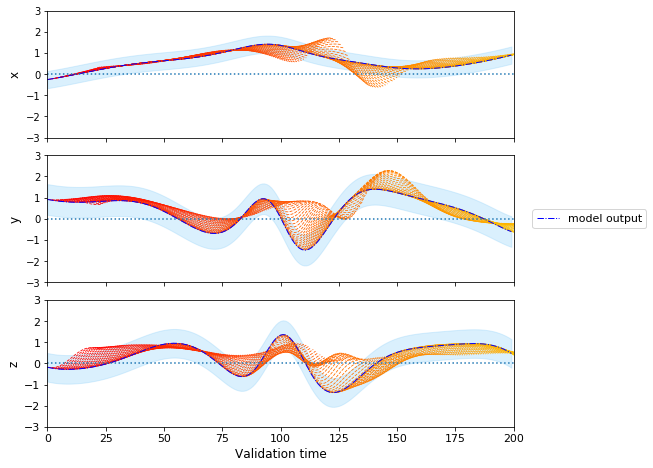

In [16]:
    ##################################################################################################
    ########    visualization of lead time dependent prediction - timeseries with lead time   ########
    ##################################################################################################
    #colormap=cm.Accent(range(ens))
    #colormap=cm.Set1(range(ens))
    #colormap=cm.tab10(range(ens))
    #colormap=cm.tab20c(range(ens))
    #colormap=cm.jet(range(ens))
    
    # Get colors from colormap
    #colormap = plt.get_cmap('coolwarm', step_lead)
    #colormap = plt.get_cmap('jet', 51)    

    colormap=cm.autumn(range(test_len))
    
    index = np.arange(test_len)
    index_lead = np.arange(test_len + display_upto)
    
    fig06 = plt.figure()
    fig06, (ax1,ax2,ax3) = plt.subplots(3, 1, sharex=True)
    fig06.set_size_inches(9.2, 6.6, forward=True)
    
    # VAR forecast
    #deterministic
    for i in range(test_len):
        ax1.plot(index_lead[i:i+display_upto], deter_pred_xyz[0,i,:display_upto],
                         color=colormap[i], linestyle='dashed', linewidth = 0.8)
        ax2.plot(index_lead[i:i+display_upto], deter_pred_xyz[1,i,:display_upto],
                         color=colormap[i], linestyle='dashed', linewidth = 0.8)
        ax3.plot(index_lead[i:i+display_upto], deter_pred_xyz[2,i,:display_upto],
                         color=colormap[i], linestyle='dashed', linewidth = 0.8)
        
    # obs
    ax1.plot(index, x[-test_len:], color='blue', linestyle='dashdot', linewidth = 1.0, label='model output')
    ax2.plot(index, y[-test_len:], color='blue', linestyle='dashdot', linewidth = 1.0, label='model output')
    ax3.plot(index, z[-test_len:], color='blue', linestyle='dashdot', linewidth = 1.0, label='model output')
    # obs std band
    ax1.fill_between(index, x[-test_len:] + x_std, x[-test_len:] - x_std,
                     alpha=0.3,edgecolor='lightskyblue', facecolor='lightskyblue')
    ax2.fill_between(index, y[-test_len:] + y_std, y[-test_len:] - y_std,
                     alpha=0.3,edgecolor='lightskyblue', facecolor='lightskyblue')
    ax3.fill_between(index, z[-test_len:] + z_std, z[-test_len:] - z_std,
                     alpha=0.3,edgecolor='lightskyblue', facecolor='lightskyblue')    
    
    ax1.axhline(y=0, ls = ':')
    ax2.axhline(y=0, ls = ':')
    ax3.axhline(y=0, ls = ':')    
    
    ax1.set_ylim(-3, 3)
    ax2.set_ylim(-3, 3)
    ax3.set_ylim(-3, 3)

    ax1.set_xlim(0, test_len)
    ax2.set_xlim(0, test_len)
    ax3.set_xlim(0, test_len)
    
    #ax1.legend(frameon=True, loc=3, prop={'size': 7.5}, ncol=7)
    ax2.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0, prop={'size': 11.0}, ncol=2)
    #ax3.legend(frameon=True, loc=3, prop={'size': 7.5}, ncol=7)

    ax1.set_ylabel("x", fontsize=12)
    ax2.set_ylabel("y", fontsize=12)
    ax3.set_ylabel("z", fontsize=12)
    
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
    plt.xlabel("Validation time", fontsize=12)
    
    plt.tight_layout()
    plt.show()
    fig06.savefig(os.path.join(output_path,'VAR_deter_forecast_lorenz_series.png'),dpi=150)

<Figure size 432x288 with 0 Axes>

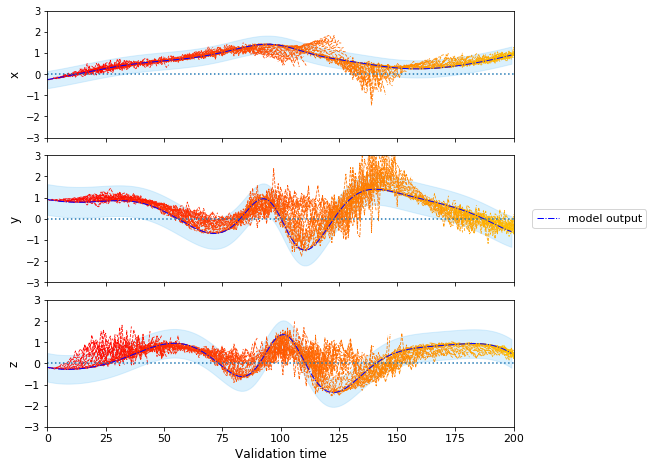

In [17]:
    ##################################################################################################
    ########    visualization of lead time dependent prediction - timeseries with lead time   ########
    ##################################################################################################
    #colormap=cm.Accent(range(ens))
    #colormap=cm.Set1(range(ens))
    #colormap=cm.tab10(range(ens))
    #colormap=cm.tab20c(range(ens))
    #colormap=cm.jet(range(ens))
    
    # Get colors from colormap
    #colormap = plt.get_cmap('coolwarm', step_lead)
    #colormap = plt.get_cmap('jet', 51)    

    colormap=cm.autumn(range(test_len))
    
    index = np.arange(test_len)
    index_lead = np.arange(test_len + display_upto)
    
    fig07 = plt.figure()
    fig07, (ax1,ax2,ax3) = plt.subplots(3, 1, sharex=True)
    fig07.set_size_inches(9.2, 6.6, forward=True)
    
    # VAR forecast   
    # probabilistic
    for i in range(test_len):
        ax1.plot(index_lead[i:i+display_upto], prob_pred_xyz[4,0,i,:display_upto],
                         color=colormap[i], linestyle='dashed', linewidth = 0.8)
        ax2.plot(index_lead[i:i+display_upto], prob_pred_xyz[4,1,i,:display_upto],
                         color=colormap[i], linestyle='dashed', linewidth = 0.8)
        ax3.plot(index_lead[i:i+display_upto], prob_pred_xyz[4,2,i,:display_upto],
                         color=colormap[i], linestyle='dashed', linewidth = 0.8)
        
    # obs
    ax1.plot(index, x[-test_len:], color='blue', linestyle='dashdot', linewidth = 1.0, label='model output')
    ax2.plot(index, y[-test_len:], color='blue', linestyle='dashdot', linewidth = 1.0, label='model output')
    ax3.plot(index, z[-test_len:], color='blue', linestyle='dashdot', linewidth = 1.0, label='model output')
    # obs std band
    ax1.fill_between(index, x[-test_len:] + x_std, x[-test_len:] - x_std,
                     alpha=0.3,edgecolor='lightskyblue', facecolor='lightskyblue')
    ax2.fill_between(index, y[-test_len:] + y_std, y[-test_len:] - y_std,
                     alpha=0.3,edgecolor='lightskyblue', facecolor='lightskyblue')
    ax3.fill_between(index, z[-test_len:] + z_std, z[-test_len:] - z_std,
                     alpha=0.3,edgecolor='lightskyblue', facecolor='lightskyblue')    
    
    ax1.axhline(y=0, ls = ':')
    ax2.axhline(y=0, ls = ':')
    ax3.axhline(y=0, ls = ':')    
    
    ax1.set_ylim(-3, 3)
    ax2.set_ylim(-3, 3)
    ax3.set_ylim(-3, 3)

    ax1.set_xlim(0, test_len)
    ax2.set_xlim(0, test_len)
    ax3.set_xlim(0, test_len)
    
    #ax1.legend(frameon=True, loc=3, prop={'size': 7.5}, ncol=7)
    ax2.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0, prop={'size': 11.0}, ncol=2)
    #ax3.legend(frameon=True, loc=3, prop={'size': 7.5}, ncol=7)

    ax1.set_ylabel("x", fontsize=12)
    ax2.set_ylabel("y", fontsize=12)
    ax3.set_ylabel("z", fontsize=12)
    
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
    plt.xlabel("Validation time", fontsize=12)
    
    plt.tight_layout()
    plt.show()
    fig07.savefig(os.path.join(output_path,'VAR_prob_forecast_lorenz_series_onlyOne.png'),dpi=150)

===================    trajectory - truncated  =====================


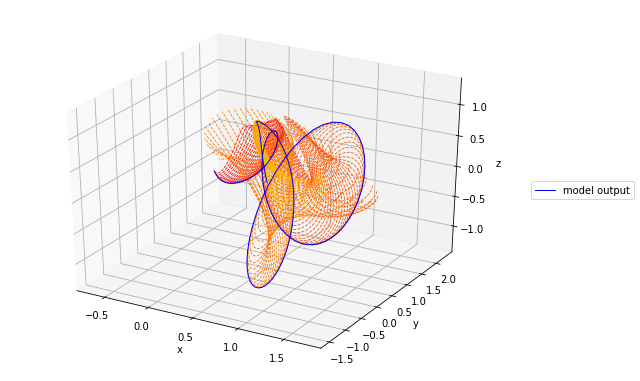

In [18]:
    ###################################################################################
    ########    visualization of lead time dependent prediction - trajectory   ########
    ###################################################################################
    print ('===================    trajectory - truncated  =====================')
    #colormap=cm.Accent(range(ens))
    #colormap=cm.Set1(range(ens))
    #colormap=cm.tab10(range(ens))
    #colormap=cm.tab20c(range(ens))
    #colormap=cm.jet(range(ens))
    
    # Get colors from colormap
    #colormap = plt.get_cmap('coolwarm', step_lead)
    #colormap = plt.get_cmap('jet', 51)    

    colormap=cm.autumn(range(test_len))
    
    fig08 = plt.figure(figsize=(9,5.4))
    ax = fig08.gca(projection='3d')
    
    # VAR forecast
    for i in range(test_len):
        ax.plot(deter_pred_xyz[0,i,:display_upto], deter_pred_xyz[1,i,:display_upto],
                deter_pred_xyz[2,i,:display_upto], color=colormap[i], linestyle='dashed', linewidth = 0.8)
        
    # ground truth
    ax.plot(x[-test_len:], y[-test_len:], z[-test_len:],
            color='blue', label='model output', lw=1.0)
    
    # for check only
    #ax.plot(deter_pred_xyz[0,:,10], deter_pred_xyz[1,:,10], deter_pred_xyz[2,:,10],
    #        color='green', label='model output', lw=1.0)    

    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    #ax.set_title("Lorenz-84 model")
    plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0, prop={'size': 10.0})
    plt.tight_layout()
    plt.show()
    fig08.savefig(os.path.join(output_path, 'VAR_deter_forecast_lorenz_trajectory.png'),dpi=150)

===================    trajectory - truncated  =====================


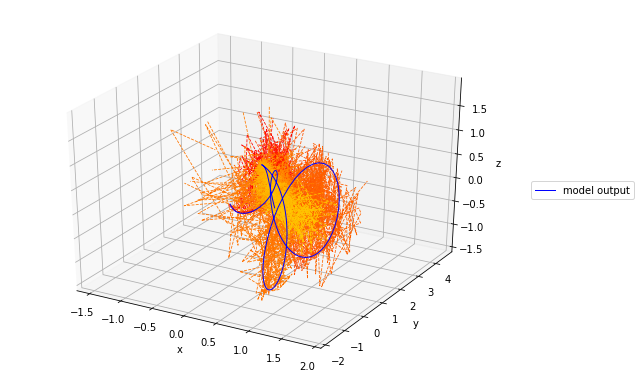

In [19]:
    ###################################################################################
    ########    visualization of lead time dependent prediction - trajectory   ########
    ###################################################################################
    print ('===================    trajectory - truncated  =====================')
    #colormap=cm.Accent(range(ens))
    #colormap=cm.Set1(range(ens))
    #colormap=cm.tab10(range(ens))
    #colormap=cm.tab20c(range(ens))
    #colormap=cm.jet(range(ens))
    
    # Get colors from colormap
    #colormap = plt.get_cmap('coolwarm', step_lead)
    #colormap = plt.get_cmap('jet', 51)    

    colormap=cm.autumn(range(test_len))
    
    fig08 = plt.figure(figsize=(9,5.4))
    ax = fig08.gca(projection='3d')
    
    # VAR forecast
    for i in range(test_len):
        ax.plot(prob_pred_xyz[4,0,i,:display_upto], prob_pred_xyz[4,1,i,:display_upto],
                prob_pred_xyz[4,2,i,:display_upto], color=colormap[i], linestyle='dashed', linewidth = 0.8)
        
    # ground truth
    ax.plot(x[-test_len:], y[-test_len:], z[-test_len:],
            color='blue', label='model output', lw=1.0)
    
    # for check only
    #ax.plot(deter_pred_xyz[0,:,10], deter_pred_xyz[1,:,10], deter_pred_xyz[2,:,10],
    #        color='green', label='model output', lw=1.0)    

    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    #ax.set_title("Lorenz-84 model")
    plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0, prop={'size': 10.0})
    plt.tight_layout()
    plt.show()
    fig08.savefig(os.path.join(output_path, 'VAR_prob_forecast_lorenz_trajectory.png'),dpi=150)